In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt
from networks.nano_gpt import GPTConfig


/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luca-fanselau (adl-for-cv). Use `wandb login --relogin` to force relogin


In [3]:
torch.cuda.is_available()

True

In [4]:


# Load tokenized dataset
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

kwargs = {
"type": "pretrained",
"fixed_label": 5,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_path = os.path.join(data_root, "models", "vqs", "vq_mnist.pt")
vq_dicts = torch.load(vq_path)
# state_dict and vq_config are used to save the model
vq_config = vq_dicts["vq_config"]
vq = VectorQuantize(**vq_config)


data_root = os.path.join(dir_path, "adl4cv")

dataset= MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)



In [5]:
indices = []
for i in range(1000):
   indices.append(dataset[i][0].max().item())

max(indices)

1013

In [9]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=2.5e-3
config.max_iters = 20000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.1*config.max_iters
config.batch_size = 16
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250

# Config Transforemer
factor = 2
model_config = GPTConfig(n_embd=144, block_size=len(dataset[0][0]), n_head=12, n_layer=12)

In [10]:

# Assume these configurations are defined somewhere in your code.
n = 512

def get_batch(split: str):
    batch_size = config.batch_size
    
    # Generate random indices for batch selection
    indices = torch.randint(0, n, (batch_size,))
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        sos_token = torch.Tensor([0]).long()  # Start of sequence token
        sample = torch.cat((sos_token, sample), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.
    x = x[:, :model_config.block_size]
    y = y[:, :model_config.block_size]

    # x and y have to be
    x = x.to(config.device)
    y = y.to(config.device)

    return x, y

In [12]:
# Prepeare model parameters and train
training_nano_gpt.train(get_batch, config, model_config)

Initializing a new model from scratch
number of parameters: 3.16M
num decayed parameter tensors: 50, with 3,218,832 parameters
num non-decayed parameter tensors: 98, with 22,752 parameters
using fused AdamW: True


iter,▁█
lr,▁█
mfu,▁▁
train/loss,█▁
val/loss,█▁
iter,250
lr,0.00031
mfu,-100.0
train/loss,4.276
val/loss,4.27203


step 0: train loss 6.9567, val loss 6.9560
step 250: train loss 4.2789, val loss 4.2897
saving checkpoint to models/token_transformer
step 500: train loss 3.7219, val loss 3.7045
saving checkpoint to models/token_transformer
step 750: train loss 3.6472, val loss 3.6440
step 1000: train loss 3.6109, val loss 3.6001
step 1250: train loss 3.5422, val loss 3.5509
step 1500: train loss 3.4550, val loss 3.4494
saving checkpoint to models/token_transformer
step 1750: train loss 3.3381, val loss 3.3154
step 2000: train loss 3.1719, val loss 3.1820
saving checkpoint to models/token_transformer
step 2250: train loss 2.9312, val loss 2.9646
saving checkpoint to models/token_transformer
step 2500: train loss 2.7539, val loss 2.7329
saving checkpoint to models/token_transformer
step 2750: train loss 2.5414, val loss 2.5886
saving checkpoint to models/token_transformer
step 3000: train loss 2.2674, val loss 2.3274
saving checkpoint to models/token_transformer
step 3250: train loss 2.1588, val loss 2

In [ ]:
import matplotlib.pyplot as plt
import torch
from animation.util import backtransform_weights
from data.neural_field_datasets import MinMaxTransform  
from networks.nano_gpt import GPT
from utils import get_default_device

# Assuming the following classes and functions are defined elsewhere:
# - INR
# - dataset_no_transform
# - ae_trained
# - dataset_flatten



# Configuration
idx = 3

device = get_default_device()

model_dict = torch.load("./models/ckpt.pt")
model = GPT(model_dict["model_args"])
model.load_state_dict(model_dict["model"])
model.to(device=device)


sample = dataset[idx][0]
X, Y = get_batch("")
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
# autoregressive process
seq = torch.zeros((1, 594)).long().to(device=device)
X = X.to(device=torch.device("cuda"))
seq[0][0] = X[0][0]

for i in range(0, model_config.block_size):
    pred, _loss = model(seq[:, :-1], Y)
    seq[0][i + 1] = pred[0][i].argmax()



number of parameters: 1.67M


In [ ]:
pred, _ = model(X, Y)
model_weights_test = vq.get_codes_from_indices((pred.argmax(dim=-1).to("cpu")-1))

In [ ]:
model_weights_test.size()

torch.Size([1, 593, 1])

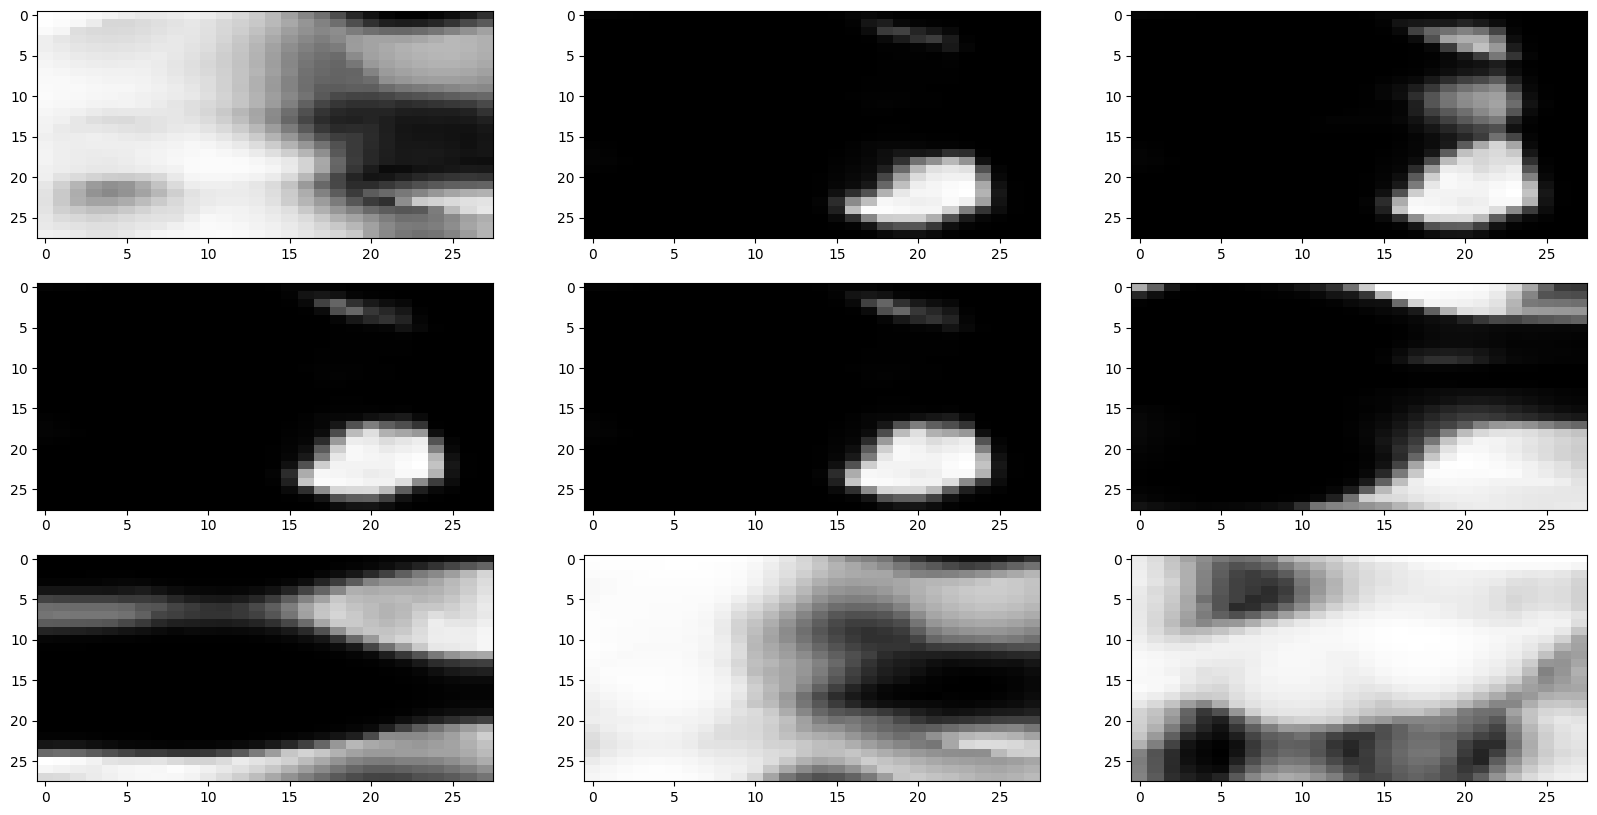

In [ ]:
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 3
# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(ij_len, ij_len, figsize=(20, 10))

SOS = torch.Tensor([[0]]).long().to(device)

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        novel_tokens = model.generate(SOS, 593, temperature=1.1, top_k=3)[:, 1:].unsqueeze(-1).to("cpu")
        novel_weights= vq.get_codes_from_indices((novel_tokens-1))

        dataset_no_transform = MnistNeFDataset(data_root_ours, **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')

plt.show()

In [ ]:
pred, _ = model(X, Y)

In [ ]:
pred.size()

torch.Size([1, 593, 1024])

In [ ]:
torch.sum((pred.argmax(dim=-1)==Y).int())

tensor(587, device='cuda:0')